This tutorial explains how to use PyTomography to reorient reconstructed objects, especially cardiac images. In this notebook, we will work with cardiac SPECT images. The methods used in the related functions are primarily inspired by Germano et al. [1]. 

In the first section we will perform the `Reconstruction` and in the second part `Reorientation` will be done.

#### References

1. G Germano et al. "Automatic reorientation of three-dimensional, transaxial myocardial perfusion SPECT images." J Nucl Med. 1995 Jun;36(6):1107-14. PMID: 7769436.


### Reconstruction

Let's import the requiret libraries.

In [1]:
import os
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
import pytomography
import matplotlib.pyplot as plt
import torch

In [2]:
# Change this to where you downloade the data
PATH = '/mnt/mydisk2/pytomo_tutorial_data/SPECT/Tc99m-Cardiac'

In this step, we define the path to the DICOM file, retrieve object and projection metadata, and extract photopeak projection images for further analysis.

In [3]:
file_NM = os.path.join(PATH, 'anonymized_file.dcm')
object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=0)
photopeak = dicom.get_projections(file_NM, index_peak=0)

Define the PSF metadata, create the system matrix, initialize the Poisson log-likelihood model, and perform reconstruction using the OSEM algorithm with specified iterations and subsets.

In [4]:
psf_meta = dicom.get_psfmeta_from_scanner_params('SY-LEHR', energy_keV=140.5)
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta)
likelihood = PoissonLogLikelihood(system_matrix, photopeak)
reconstruction_algorithm = OSEM(likelihood)
recon = reconstruction_algorithm(n_iters=4, n_subsets=8)

Next, we visualize the reconstructed object in three different views: sagittal, coronal, and axial. Based on the sagittal and coronal views, we can isolate the cardiac area and remove the rest of the slices. This is why `testObject = recon[:,:,30:45]` is defined this way. Using the `get_mask()` function, we can define `testObjectMask` to segment the cardiac region.

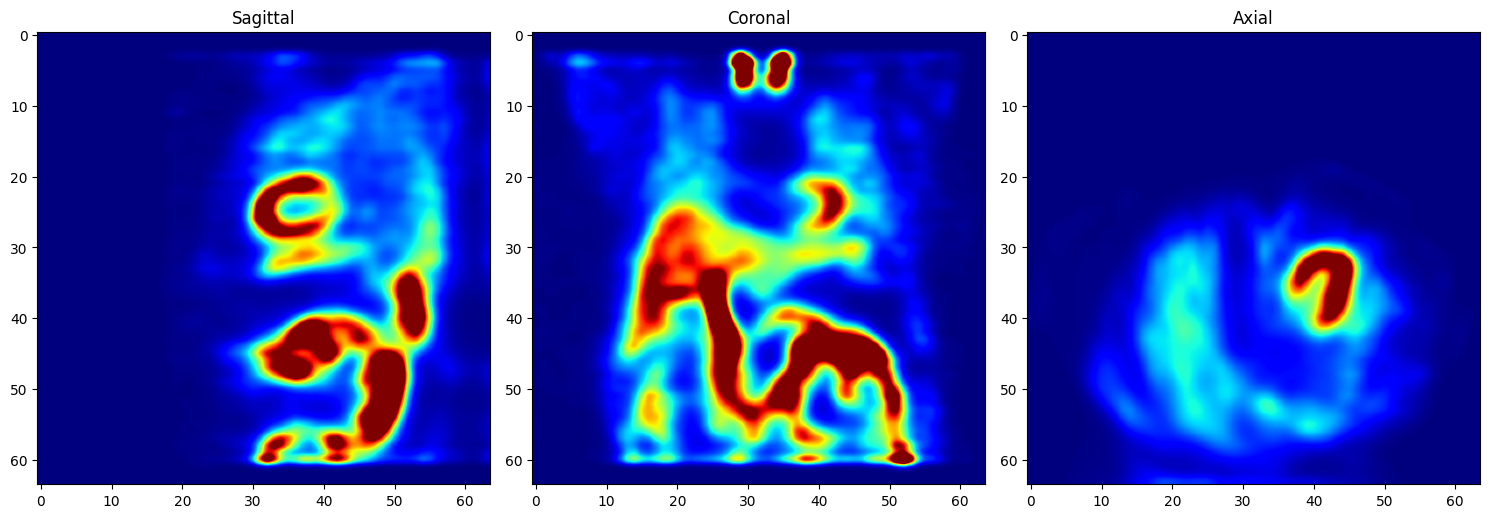

In [5]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(torch.rot90(recon[40, :, :].cpu(), k=1, dims=[0, 1]), interpolation='gaussian', vmax=10, cmap='jet')
axs[0].set_title('Sagittal')
axs[1].imshow(torch.rot90(recon[:, 40, :].cpu(), k=1, dims=[0, 1]), interpolation='gaussian', vmax=10, cmap='jet')
axs[1].set_title('Coronal')
axs[2].imshow(torch.rot90(torch.flip(recon[:, :, 40].cpu(), dims=[1]), k=1, dims=[0, 1]), interpolation='gaussian', vmax=10, cmap='jet')
axs[2].set_title('Axial')
plt.tight_layout()
plt.show()

In case you want to save the reconstructed object you can set the path for saving the reconstruction, remove any existing folder, and save the DICOM file using the specified reconstruction parameters.

In [6]:
# # Modify the path below to a location on your computer where you want to save the data
# save_path = '/home/jhubadmin/Desktop/Reorientation/reconstructed/'
# # # Code only works if folder doesnt exist, so delete it if present
# if os.path.exists(save_path) and os.path.isdir(save_path):
#     shutil.rmtree(save_path)
# # Save
# dicom.save_dcm(
#     save_path = save_path,
#     object = recon,
#     file_NM = file_NM,
#     recon_name = 'OSEM_4it_8ss')

### Reorientation

The next step is to find the offset of the segmented region relative to the center of the coordinate system. In the axial and sagittal views, we first find the appropriate slice where the heart region is clearly visible (usually the middle one). We then find the center of mass of the segmented region and calculate the `tx`, `ty`, and `tz` values using the `get_shift_values()` function. We also obtain the `ShiftedAxial` and `ShiftedSagittal` slices from the same function. Using these shifted slices, we use the `get_angle()` function to find the proper angles: `AxialAngle` and `SagittalAngle`. Also, you may have masked image at the end using `masking()` function.


In [7]:
from pytomography.utils.cardiac_spect import get_mask, get_shift_values, get_angle, shift_object, rotate_object, plot_arrow, create_circular_mask, masking

# Define the object and get the mask
testObject = recon[:,:,30:45]
testObjectMask = get_mask(testObject, 0.55, 0.9)

# Finding the shift values
ShiftedAxial, ty, tx = get_shift_values(testObjectMask[:,:,7])
ShiftedSagittal, _, tz = get_shift_values(testObjectMask[40,:,:])

# Finding the angles values
AxialAngle = get_angle(
    ShiftedAxial,
    torch.linspace(240, 270, 100).to(pytomography.device)
)
SagittalAngle = get_angle(
    ShiftedSagittal,
    torch.linspace(335, 355, 100).to(pytomography.device)
)

# Shifting the object
ShiftedObject = shift_object(testObject, -tx, -ty, -tz)

# Rotating the object
RotatedObject = rotate_object(ShiftedObject, AxialAngle, SagittalAngle)

# Make sure the object does not contain negatinve values
RotatedObject = torch.clamp(RotatedObject, min=0)

# Permute the object to the correct orientation
RotatedObject = RotatedObject.permute(2, 1, 0)

# Perform masking on the RotatedObject
maskedObject = masking(RotatedObject, radius=10)

Using the obtained `tx`, `ty`, `tz`, `AxialAngle`, and `SagittalAngle`, we can perform the reorientation using the `shift_object()` and `rotate_object()` functions. To ensure the selected variables are correct, plot the slices for shifting and rotations. Specifically, for finding the angle, use `plot_arrow()` to visualize and determine the correct angle more easily. Finally, use the `masking()` function to remove any extra spaces.


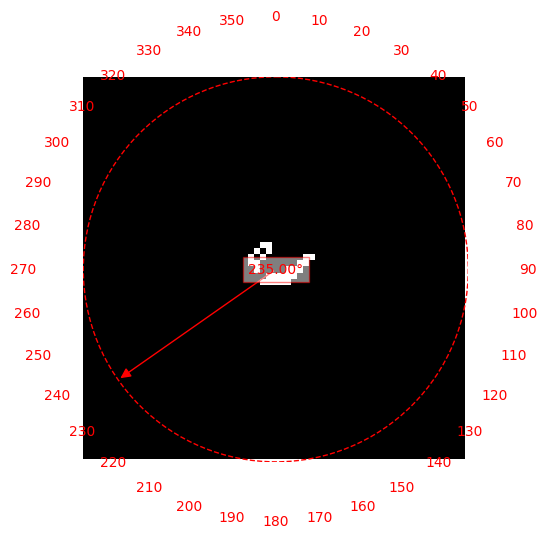

In [8]:
plot_arrow(ShiftedAxial, 235)

At the end of this process, you will have reoriented the reconstructed object from the conventional views (sagittal, coronal, and axial) to the Horizontal Long Axis (HLA), Vertical Long Axis (VLA), and Short Axis (SA) views. Let's visulize both masked and non-masked results.

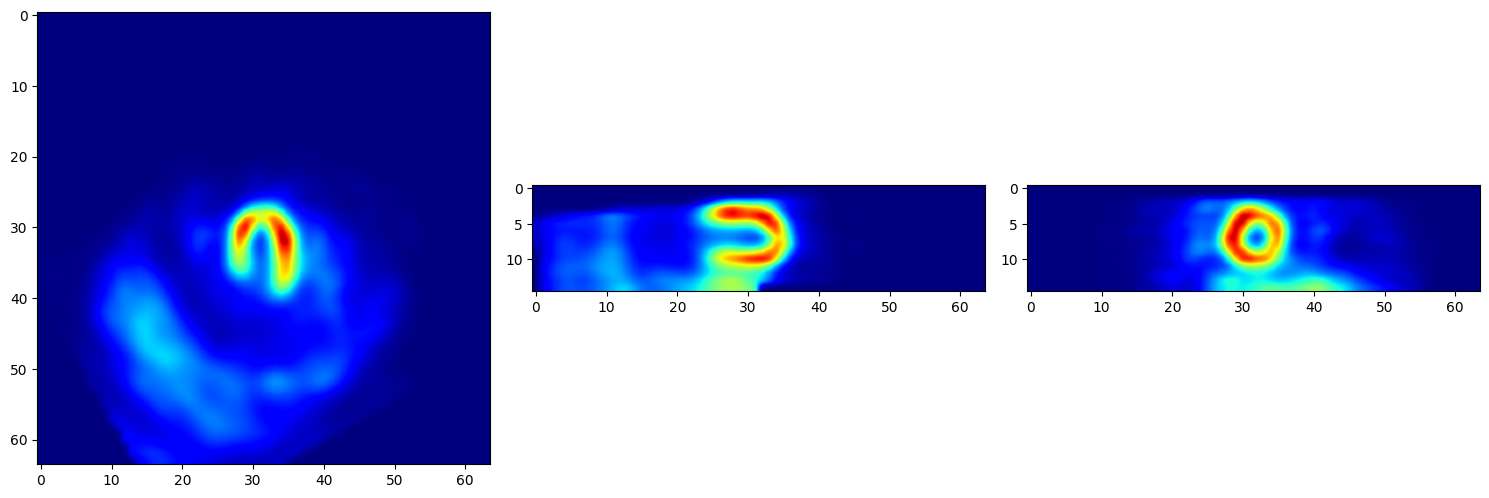

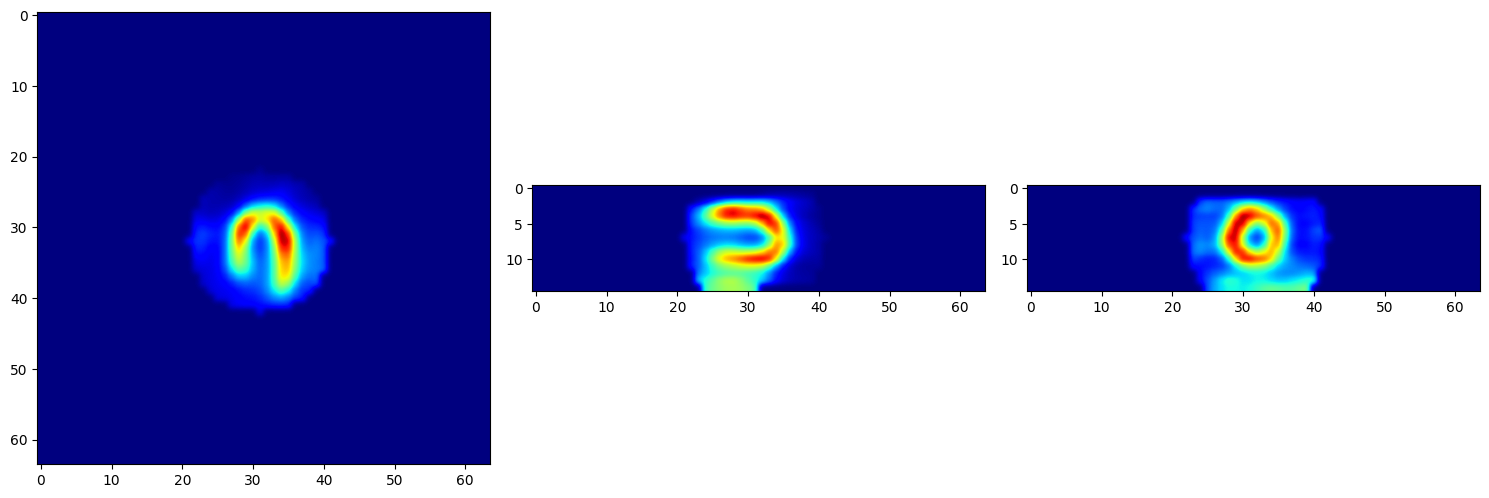

In [9]:
def plot_views(tensor: torch.Tensor):
    """
    Plots three different views of the given 3D tensor

    Args:
        tensor (torch.Tensor): 3D tensor with shape [depth, height, width].
    """
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Vertical Long Axis (VLA)
    vla_image = torch.flip(tensor[7, :, :].cpu(), dims=[0]).T
    axs[0].imshow(vla_image, interpolation='gaussian', cmap='jet')

    # Horizontal Long Axis (HLA)
    hla_image = torch.flip(torch.flip(tensor[:, 32, :].cpu(), dims=[0]), dims=[1])
    axs[1].imshow(hla_image, interpolation='gaussian', cmap='jet')

    # Short Axis (SA)
    sa_image = torch.flip(tensor[:, :, 32].cpu(), dims=[0])
    axs[2].imshow(sa_image, interpolation='gaussian', cmap='jet')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
plot_views(RotatedObject)
plot_views(maskedObject)